In [2]:
library(tidyverse)
library(tidymodels)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [42]:
options(repr.matrix.max.rows = 6)

cleveland_disease_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")
colnames(cleveland_disease_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num") 
cleveland_disease_data 

cleveland_clean <- cleveland_disease_data |>
mutate(angina = ifelse(is.na(exang), NA, (exang > 0))) |>
mutate(exang = as.factor(as.integer(exang)))

cleveland_split <- initial_split(cleveland_clean, prop = 3/4, strata = angina)

cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

head(cleveland_training)
                           


New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,angina
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<lgl>
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,FALSE
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3,FALSE
57,1,4,140,192,0,0,148,0,0.4,2,0.0,6.0,0,FALSE
56,0,2,140,294,0,2,153,0,1.3,2,0.0,3.0,0,FALSE
44,1,2,120,263,0,0,173,0,0.0,1,0.0,7.0,0,FALSE
48,1,2,110,229,0,0,168,0,1.0,3,0.0,7.0,1,FALSE


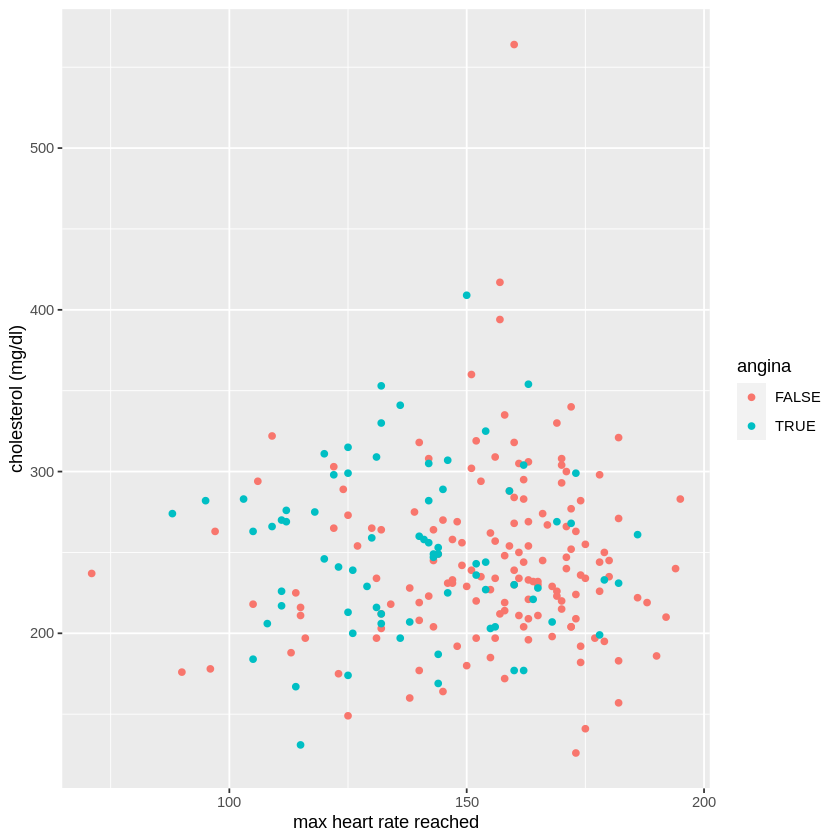

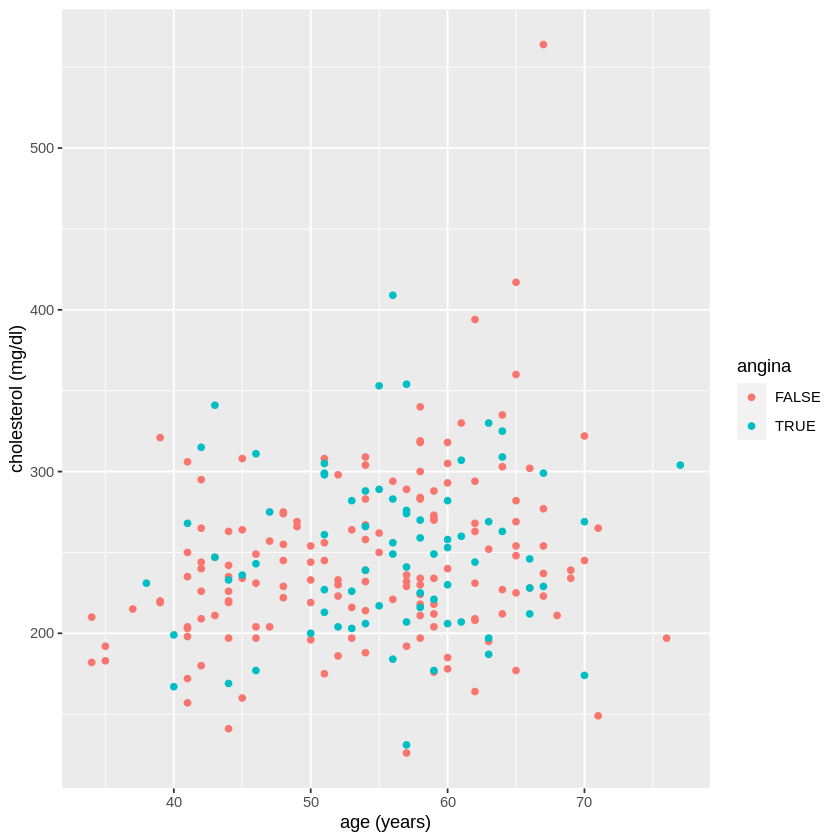

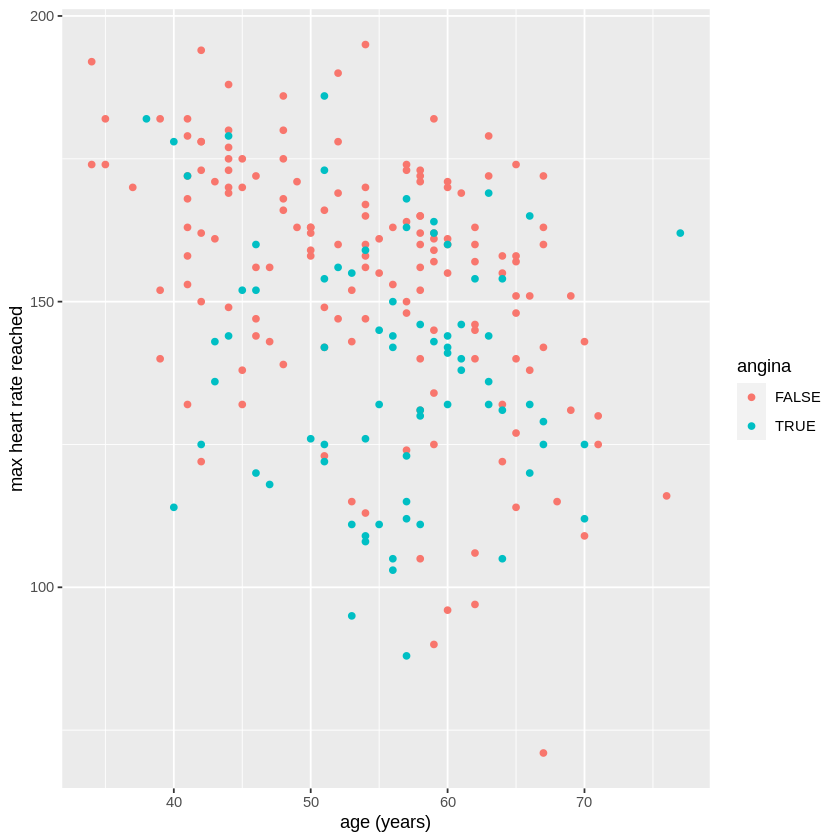

In [43]:
plot1 <- ggplot(cleveland_training, aes(x = thalach, y = chol, color = angina)) +
                 geom_point() +
                 labs(x = "max heart rate reached", y = "cholesterol (mg/dl)", color = "angina") 
                

plot2 <- ggplot(cleveland_training, aes(x = age, y = chol, color = angina)) +
                 geom_point() +
                 labs(x = "age (years)", y = "cholesterol (mg/dl)", color = "angina") 
                 
plot3 <- ggplot(cleveland_training, aes(x = age, y = thalach, color = angina)) +
                 geom_point() +
                 labs(x = "age (years)", y = "max heart rate reached", color = "angina") 
                 
plot1
plot2
plot3